In [1]:
# default_exp analyses

In [2]:
#| code-summary: -- load dependencies and data and select parameters
#| output: asis

from compmemlearn.analyses import recall_by_all_study_positions

analysis_overview = """
# Probability of First Recall
The probability of starting free recall with the item at each position in a studied sequence or list.
"""

analysis_tag = 'pfr'
data_paths = ["../../data/CDCATBEH.csv", "../../data/LohnasKahana2014.csv", "../../data/HowardKahana2005.csv"]
trial_queries = [
    ["list_type == 'light'", "list_type == 'heavy'"], 
    ["condition == 1", "condition == 2", "condition == 3", "condition == 4"], 
    ["condition == 0", "condition == 1", "condition == 2"]
    ]
query_labels = trial_queries

show_figure = True
regenerate_figure = True
section_tags = ["CDCATBEH", "LohnasKahana2014", "HowardKahana2005"]
figures_path = "figures/"
figures_path = "figures/"
figure_caption = """Rate of first recall by serial position measured as a function of list length using data from @{}."""

print(analysis_overview)


# Probability of First Recall
The probability of starting free recall with the item at each position in a studied sequence or list.



In [3]:
# export
#| code-summary: -- specify serial position effect analysis code

from compmemlearn.datasets import events_metadata, generate_trial_mask
import matplotlib.pyplot as plt
from numba import njit
import seaborn as sns
import pandas as pd
import numpy as np

@njit(nogil=True)
def fast_pfr(trials, item_count):
    return np.bincount(trials[:, 0], minlength=item_count + 1)[1:] / len(trials)

@njit(nogil=True)
def flex_mixed_pfr(trials, presentations):
    "Variant that works for any number of item repetitions"
    
    list_length = len(presentations[0])
    result = np.zeros(list_length, dtype=np.int32)
    all_study_positions = recall_by_all_study_positions(trials, presentations) 
    first_recalls = all_study_positions[:, :, :1]
    
    for trial_index in range(len(trials)):
        for i in range(list_length):
            result[i] += i+1 in first_recalls[:, trial_index]
    
    return result/len(trials)

def plot_pfr(data, trial_query, contrast_name=None, labels=None, axis=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)[:3]
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            if (presentations == np.arange(list_length)).all():
                pfr = fast_pfr(trials[subject_specific_trial_mask], list_length)
            else:
                pfr = flex_mixed_pfr(
                    trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask])

            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "input": np.arange(1, list_length + 1),
                    "recall": pfr,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result).reset_index()

    sns.lineplot(
        ax=axis, data=result, x='input', y='recall', err_style='bars', hue=contrast_name)
    axis.set(xlabel='Study Position', ylabel='Rate of First Recall')
    axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
    axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis, result

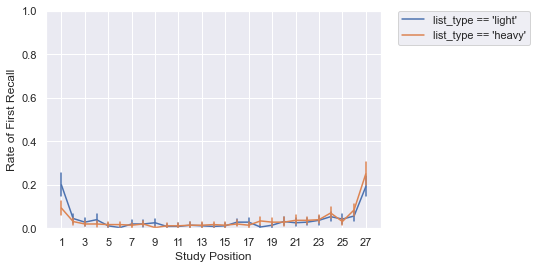

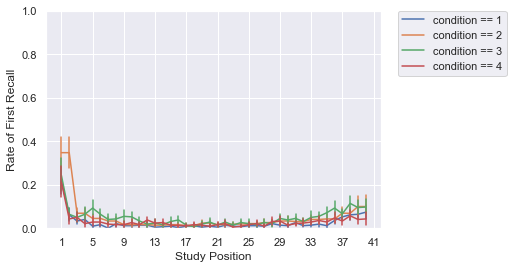

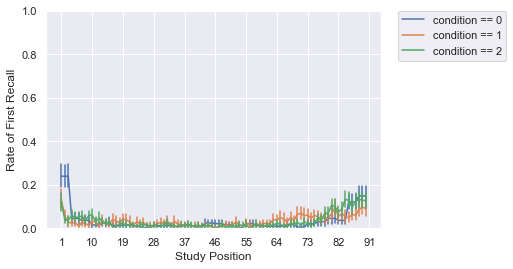

In [4]:
#| code-summary: -- perform and visualize pfr using pre-defined parameters
#| output: asis

import os.path

sns.set(style='darkgrid')

for i in range(len(data_paths)):
    section_tag = section_tags[i]
    trial_query = trial_queries[i]
    query_label = query_labels[i]
    data_path = data_paths[i]

    if regenerate_figure or show_figure:
        ax = None
        for query in trial_query:

            events = pd.read_csv(data_path)
            trials, list_lengths, presentations = events_metadata(events)[:3]
            ax = plot_pfr([events], query, labels=[query], axis=ax)[0]

        ax.legend(query_label, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        if regenerate_figure:
            plt.savefig(
                figures_path+f'{section_tag}_{analysis_tag}.pdf', bbox_inches="tight")
                
        if show_figure:
            plt.show()
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({figures_path}{section_tag}_{analysis_tag}.pdf)

{figure_caption}
:::""");
        plt.close()

    else:
        if not os.path.isfile(f'{figures_path}{section_tag}_{analysis_tag}.pdf'):
            print(
                f'Figure not found at {figures_path}{section_tag}_{analysis_tag}.pdf. Run with regenerate_figure=True to generate.')
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({figures_path}{section_tag}_{analysis_tag}.pdf)

{figure_caption}
:::""");